In [58]:
library(dplyr)
library(tidyr)
library(ggsci)
library(lfe)
library(fixest)
library(stringr)
library(ggplot2)
library(doMC)
registerDoMC(18)

In [59]:
df <- data.table::fread('/pool001/mfzhao/PROCESSED_DATA/dyadic_mvmt_2020.csv')

In [61]:
df %>% 
    filter(origin_cluster != destination_cluster) %>%
    mutate(oRain  = as.numeric(oPRCP > 0),
           dRain  = as.numeric(dPRCP > 0),
           nearby = as.numeric(dist < 100)) -> df

In [96]:
cns <- colnames(df)
cns

[1] "date"                "dyad"                "origin_cluster"     
 [4] "destination_cluster" "n"                   "bordering"          
 [7] "ndotd"               "pdotd"               "dist"               
[10] "oPRCP"               "oTMAX"               "oprcp01"            
[13] "oprcp02"             "oprcp03"             "oprcp04"            
[16] "oprcp05"             "oprcp06"             "oprcp07"            
[19] "oprcp08"             "oprcp09"             "oprcp10"            
[22] "otmax02"             "otmax03"             "otmax04"            
[25] "otmax05"             "otmax06"             "otmax07"            
[28] "otmax08"             "otmax09"             "otmax10"            
[31] "dPRCP"               "dTMAX"               "dprcp01"            
[34] "dprcp02"             "dprcp03"             "dprcp04"            
[37] "dprcp05"             "dprcp06"             "dprcp07"            
[40] "dprcp08"             "dprcp09"             "dprcp10"            
[43] "dtmax02"             "dtmax03"             "dtmax04"            
[46] "dtmax05"             "dtmax06"             "dtmax07"            
[49] "dtmax08"             "dtmax09"             "dtmax10"            
[52] "onewcases"           "onewdeaths"          "ostnewcases"        
[55] "ostnewdeaths"        "oas_newcases"        "oas_newdeaths"      
[58] "oas_stnewcases"      "oas_stnewdeaths"     "dnewcases"          
[61] "dnewdeaths"          "dstnewcases"         "dstnewdeaths"       
[64] "das_newcases"        "das_newdeaths"       "das_stnewcases"     
[67] "das_stnewdeaths"     "op1"                 "op2"                
[70] "op3"                 "dp1"                 "dp2"                
[73] "dp3"                 "op1:dp1"             "op1:dp2"            
[76] "op1:dp3"             "op2:dp1"             "op2:dp2"            
[79] "op2:dp3"             "op3:dp1"             "op3:dp2"            
[82] "op3:dp3"             "oRain"               "dRain"              
[85] "nearby"

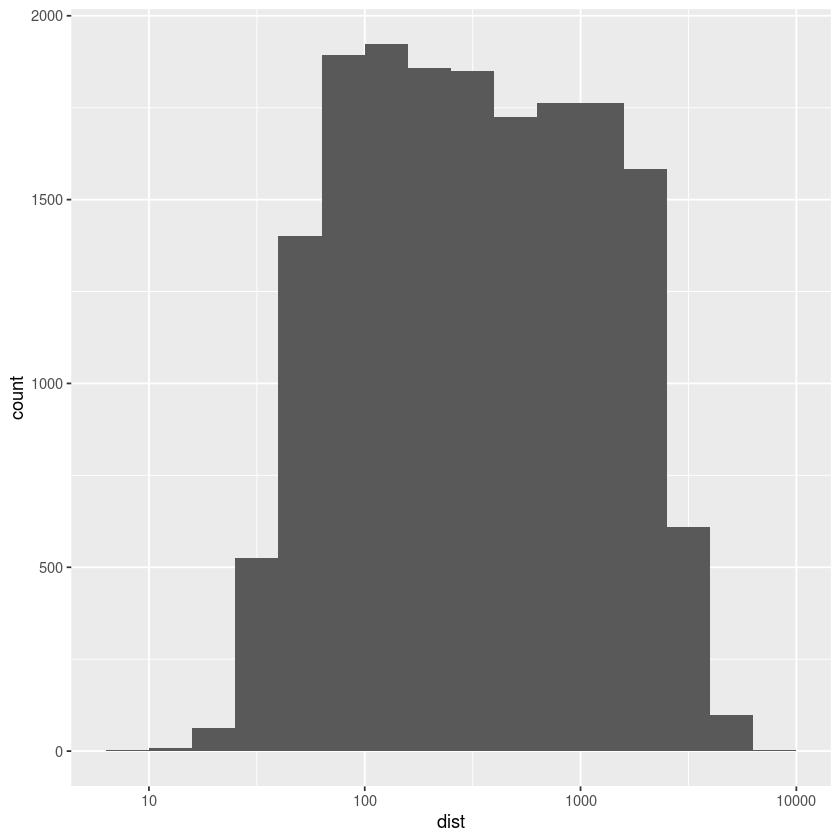

In [64]:
df %>%
    select(dyad, dist) %>%
    distinct()%>%
    ggplot(aes(x = dist)) +
    geom_histogram(binwidth = 0.2, center = 0.1) +
    scale_x_log10()

In [65]:
wctrls  <- str_c(cns[str_detect(cns, '[od][pt][rm][ca][px]..')], collapse = ' + ')
cdctrls <- str_c(cns[str_detect(cns, '[od]as_')], collapse = ' + ')
ctrls   <- str_c(wctrls, ' + ', cdctrls)

In [69]:
get_coefs <- function(dv, type) {
    if(type == 'all') {
        temp <- df
    } else {
        temp <- df %>%
            filter(nearby == ifelse(type == 'nearby', 1, 0))
    }
    
    if(dv == 'ndotd') {
        form <- str_c('log(ndotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, nthread = 20)
    } else {
        form <- str_c('log(pdotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, weights = temp$n, nthread = 20)
    }

    out <- summary(fit)$coeftable %>%
        mutate(var  = rownames(.),
               dv   = dv, 
               type = type) %>%
        filter(str_detect(var, '[od]p[123]')) %>%
        rename(estimate = Estimate, se = `Std. Error`)
    
    return(out)
}

In [71]:
foreach(dv = c('ndotd', 'pdotd'), .combine = rbind) %:%
    foreach(type = c('all', 'nearby', 'distant'), .combine = rbind) %do%
    get_coefs(dv, type) -> dyad_coefs

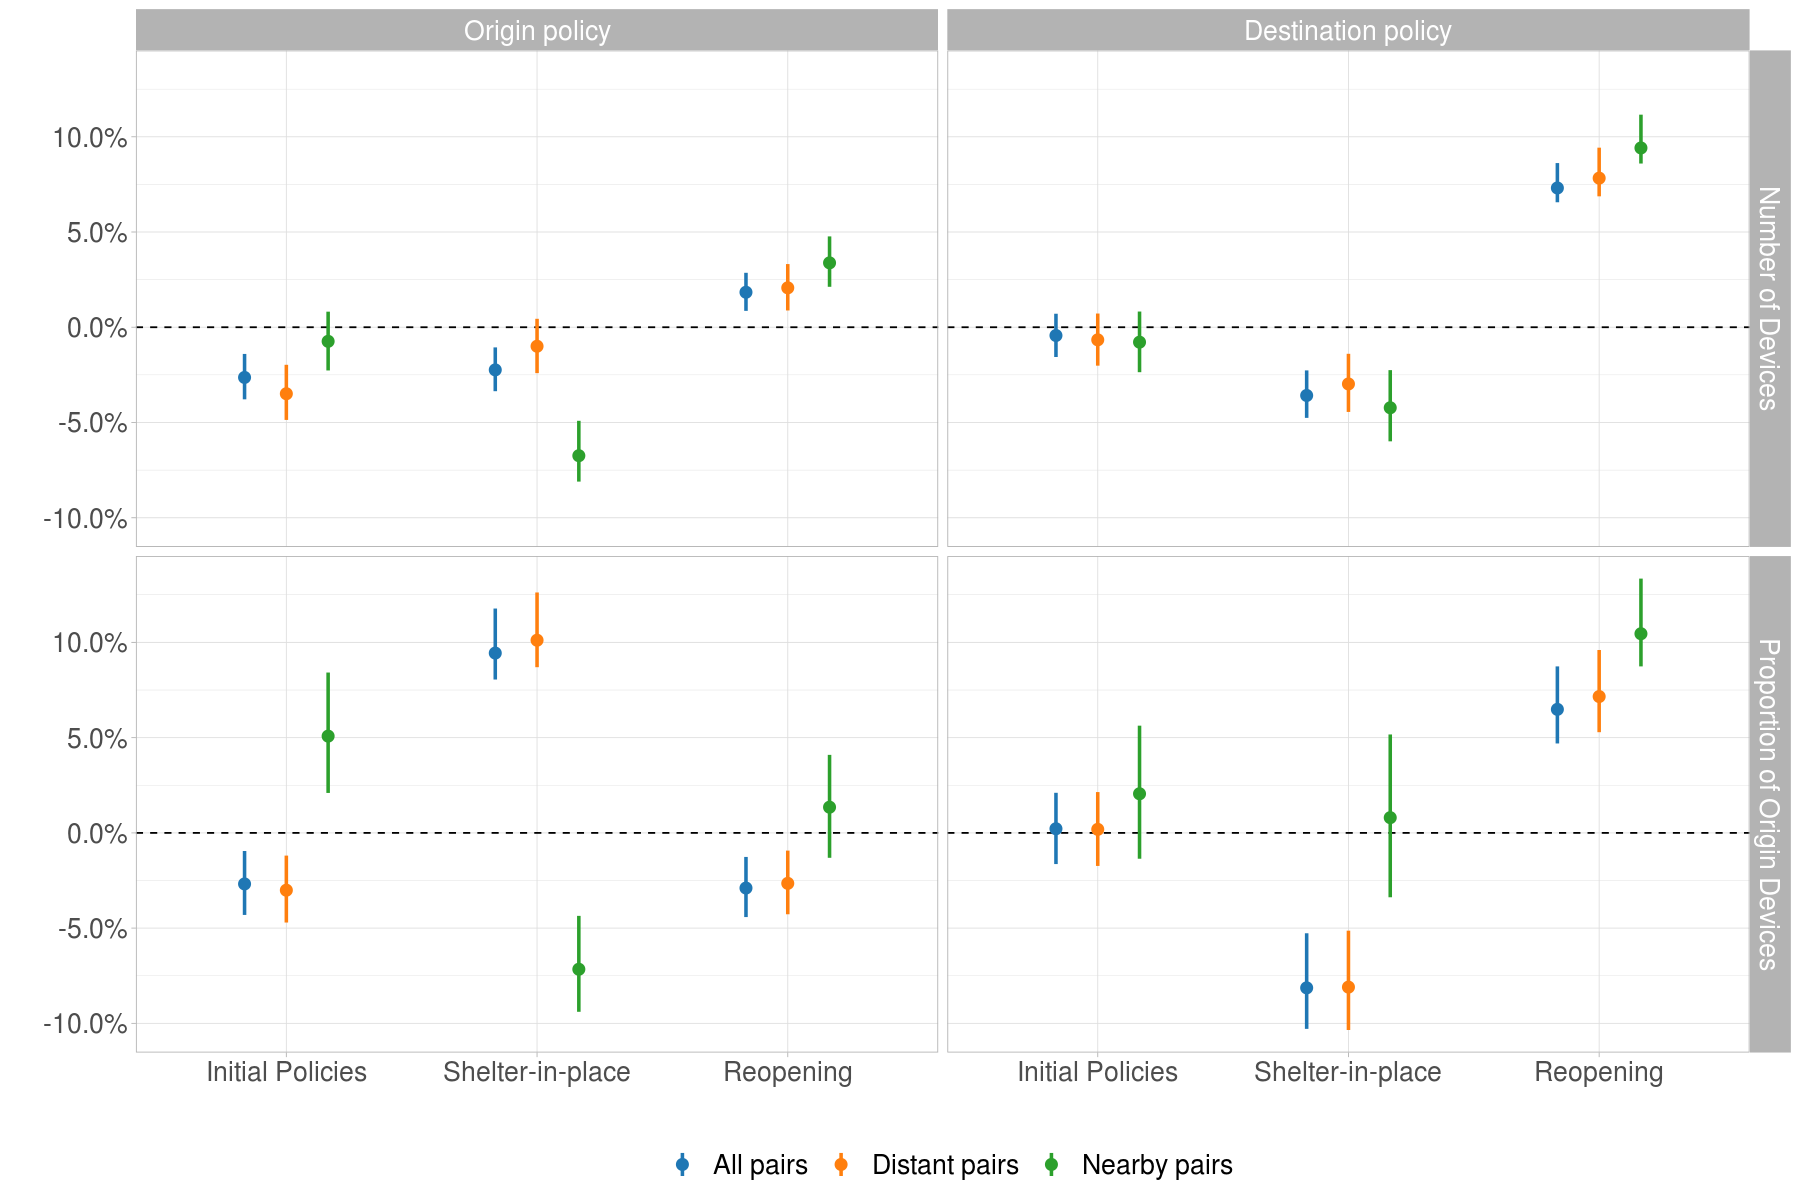

In [72]:
options(repr.plot.width=15, repr.plot.height=10)
dyad_coefs %>%
    mutate(od = ifelse(str_detect(var, 'op'), 'Origin policy', 'Destination policy'),
           od = factor(od, c('Origin policy', 'Destination policy')),
           var = ifelse(str_detect(var, 'p1'), 'Initial Policies', 
                        ifelse(str_detect(var, 'p2'), 'Shelter-in-place', 'Reopening')),
           var = factor(var, levels = c('Initial Policies', 'Shelter-in-place', 'Reopening')),
           dv  = ifelse(dv == 'ndotd', 'Number of Devices', 'Proportion of Origin Devices'),
           estimate = exp(estimate) - 1,
           u95ci   = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1) %>%
    ggplot(aes(x = var, y = estimate, color = type)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.5), size = 3) +
    geom_linerange(aes(ymin = l95ci, ymax = u95ci), 
                   position = position_dodge(0.5), size = 1) +
    xlab('') + 
    ylab('') +
    labs(color = '') + 
    scale_color_d3(labels = c('All pairs', 'Distant pairs', 'Nearby pairs')) + 
    scale_y_continuous(labels = scales::percent) +
    facet_grid(dv ~ od, scales = 'free_x') +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> p
p
#ggsave('/home/mfzhao/p3.pdf', p, device = 'pdf', width = 6.5, height = 5, scale = 2)

In [86]:
cns

[1] "date"                "dyad"                "origin_cluster"     
 [4] "destination_cluster" "n"                   "bordering"          
 [7] "ndotd"               "pdotd"               "dist"               
[10] "oPRCP"               "oTMAX"               "oprcp01"            
[13] "oprcp02"             "oprcp03"             "oprcp04"            
[16] "oprcp05"             "oprcp06"             "oprcp07"            
[19] "oprcp08"             "oprcp09"             "oprcp10"            
[22] "otmax02"             "otmax03"             "otmax04"            
[25] "otmax05"             "otmax06"             "otmax07"            
[28] "otmax08"             "otmax09"             "otmax10"            
[31] "dPRCP"               "dTMAX"               "dprcp01"            
[34] "dprcp02"             "dprcp03"             "dprcp04"            
[37] "dprcp05"             "dprcp06"             "dprcp07"            
[40] "dprcp08"             "dprcp09"             "dprcp10"            
[43] "dtmax02"             "dtmax03"             "dtmax04"            
[46] "dtmax05"             "dtmax06"             "dtmax07"            
[49] "dtmax08"             "dtmax09"             "dtmax10"            
[52] "onewcases"           "onewdeaths"          "ostnewcases"        
[55] "ostnewdeaths"        "oas_newcases"        "oas_newdeaths"      
[58] "oas_stnewcases"      "oas_stnewdeaths"     "dnewcases"          
[61] "dnewdeaths"          "dstnewcases"         "dstnewdeaths"       
[64] "das_newcases"        "das_newdeaths"       "das_stnewcases"     
[67] "das_stnewdeaths"     "op1"                 "op2"                
[70] "op3"                 "dp1"                 "dp2"                
[73] "dp3"                 "op1:dp1"             "op1:dp2"            
[76] "op1:dp3"             "op2:dp1"             "op2:dp2"            
[79] "op2:dp3"             "op3:dp1"             "op3:dp2"            
[82] "op3:dp3"             "oRain"               "dRain"              
[85] "nearby"

In [104]:
df %>%
    mutate(o  = ifelse(op3 == 1, 'p3',
                       ifelse(op2 == 1, 'p2', 
                              ifelse(op1 == 1, 'p1', 'p0'))),
           dp0 = 1) -> df.opmex

df.opmex %>%
    select(date, dyad, origin_cluster, destination_cluster, n, nearby, bordering, dist, 
           ndotd, pdotd, matches('[od]prcp[01][0-9]'), matches('[od]tmax[01][0-9]'), matches('[od]as_')) %>%
    bind_cols(as.data.frame(model.matrix(ndotd ~ 0 + o * (dp0 + dp1 + dp2 + dp3), df.opmex))) %>%
    mutate(`op0:dp0` = op0 * dp0,
           `op0:dp1` = op0 * dp1,
           `op0:dp2` = op0 * dp2,
           `op0:dp3` = op0 * dp3) -> df.opmex

colnames(df.opmex) <- str_replace(colnames(df.opmex), ':', '_')

In [ ]:
df.op_mex %>%
    mutate(o   = ifelse(op3 == 1, 'p3', 
                     ifelse(op2 == 1, 'p2', 
                        ifelse(op1 == 1, 'p1', 'p0'))),
           dp0 = 1) -> df.op_mex

df.op_mex %>%
    select(date, dyad, origin_cluster, destination_cluster, n, nearby, bordering, dist, 
           ndotd, pdotd, oRain, dRain, oTMAX, dTMAX) %>%
    bind_cols(as.data.frame(model.matrix(ndotd ~ 0 + o * (dp0 + dp1 + dp2 + dp3), df.op_mex))) -> df.opex

df.opex %>%
    mutate(`op0:dp0` = op0 * dp0,
           `op0:dp1` = op0 * dp1,
           `op0:dp2` = op0 * dp2,
           `op0:dp3` = op0 * dp3) -> df.opex

colnames(df.opex) <- str_replace(colnames(df.opex), ':', '_')

In [82]:
df %>%
    select(dyad, date, op1, op2, op3, dp1, dp2, dp3) %>%
    mutate(op = ifelse(op3 == 1, 3,
                       ifelse(op2 == 1, 2, 
                              ifelse(op1 == 1, 1, 0))),
           dp = ifelse(dp3 == 1, 3,
                       ifelse(dp2 == 1, 2, 
                              ifelse(dp1 == 1, 1, 0)))) %>%
    group_by(op, dp) %>%
    tally()

op,dp,n
<dbl>,<dbl>,<int>
0,0,1262386
0,1,25853
0,2,754
1,0,25956
1,1,150782
1,2,66973
1,3,3699
2,0,954
2,1,70416


In [113]:
get_coefs2 <- function(dv, type) {
    if(type == 'all') {
        temp <- df.opmex
    } else {
        temp <- df.opmex %>%
            filter(nearby == ifelse(type == 'nearby', 1, 0))
    }
    
    if(dv == 'ndotd') {
        form <- str_c('log(ndotd) ~ op1 + op2 + op0_dp1 + op0_dp2 + op1_dp1 + op1_dp2 + op1_dp3 +
                          op2_dp1 + op2_dp2 + op2_dp3 + op3_dp1 + op3_dp2 + op3_dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, nthread = 20)

    } else {
        form <- str_c('log(pdotd) ~ op1 + op2 + op0_dp1 + op0_dp2 + op1_dp1 + op1_dp2 + op1_dp3 +
                          op2_dp1 + op2_dp2 + op2_dp3 + op3_dp1 + op3_dp2 + op3_dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, weights = temp$n, nthread = 20)
    }
    
    out <- summary(fit)$coeftable %>%
        mutate(var  = rownames(.),
               dv   = dv, 
               type = type) %>%
        filter(str_detect(var, '[od]p[123]')) %>%
        rename(estimate = Estimate, se = `Std. Error`)
    
    return(out)
}

estimate,se,t value,Pr(>|t|),var,dv,type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.02489279,0.01076200,2.3130268,2.073299e-02,op1,pdotd,all
0.18925146,0.03393844,5.5763160,2.493881e-08,op2,pdotd,all
0.05029152,0.01188046,4.2331300,2.316657e-05,op0_dp1,pdotd,all
-0.17604940,0.04084090,-4.3106147,1.637133e-05,op0_dp2,pdotd,all
-0.04746390,0.01062262,-4.4681922,7.939037e-06,op1_dp1,pdotd,all
0.01071894,0.01080420,0.9921078,3.211590e-01,op1_dp2,pdotd,all
0.04005325,0.03208310,1.2484221,2.118936e-01,op1_dp3,pdotd,all
-0.07901409,0.03418524,-2.3113511,2.082532e-02,op2_dp1,pdotd,all
-0.05495629,0.01684346,-3.2627679,1.105465e-03,op2_dp2,pdotd,all


In [114]:
foreach(dv = c('ndotd', 'pdotd'), .combine = rbind) %:%
    foreach(type = c('all', 'nearby', 'distant'), .combine = rbind) %do%
    get_coefs2(dv, type) -> dyad_coefs2

In [119]:
dyad_coefs2

estimate,se,t value,Pr(>|t|),var,dv,type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.003716020,0.007024374,0.5290179,5.967999e-01,op1,ndotd,all
-0.027445424,0.032554711,-0.8430554,3.992093e-01,op2,ndotd,all
0.030491607,0.007466208,4.0839482,4.447878e-05,op0_dp1,ndotd,all
-0.112245734,0.036681605,-3.0600006,2.216798e-03,op0_dp2,ndotd,all
-0.035752925,0.006920346,-5.1663489,2.413973e-07,op1_dp1,ndotd,all
0.031172424,0.007614748,4.0936909,4.265137e-05,op1_dp2,ndotd,all
0.016609433,0.021659734,0.7668346,4.431905e-01,op1_dp3,ndotd,all
0.004846547,0.031919252,0.1518377,8.793167e-01,op2_dp1,ndotd,all
-0.021996054,0.008701461,-2.5278574,1.148504e-02,op2_dp2,ndotd,all


In [123]:
dyad_coefs2 %>%
    separate(var, into = c('origin policy', 'destination policy'))

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 12 rows [1, 2, 14, 15, 27, 28, 40, 41, 53, 54, 66, 67].”


estimate,se,t value,Pr(>|t|),origin policy,destination policy,dv,type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
0.003716020,0.007024374,0.5290179,5.967999e-01,op1,NA,ndotd,all
-0.027445424,0.032554711,-0.8430554,3.992093e-01,op2,NA,ndotd,all
0.030491607,0.007466208,4.0839482,4.447878e-05,op0,dp1,ndotd,all
-0.112245734,0.036681605,-3.0600006,2.216798e-03,op0,dp2,ndotd,all
-0.035752925,0.006920346,-5.1663489,2.413973e-07,op1,dp1,ndotd,all
0.031172424,0.007614748,4.0936909,4.265137e-05,op1,dp2,ndotd,all
0.016609433,0.021659734,0.7668346,4.431905e-01,op1,dp3,ndotd,all
0.004846547,0.031919252,0.1518377,8.793167e-01,op2,dp1,ndotd,all
-0.021996054,0.008701461,-2.5278574,1.148504e-02,op2,dp2,ndotd,all


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 12 rows [1, 2, 13, 14, 25, 26, 37, 38, 49, 50, 61, 62].”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



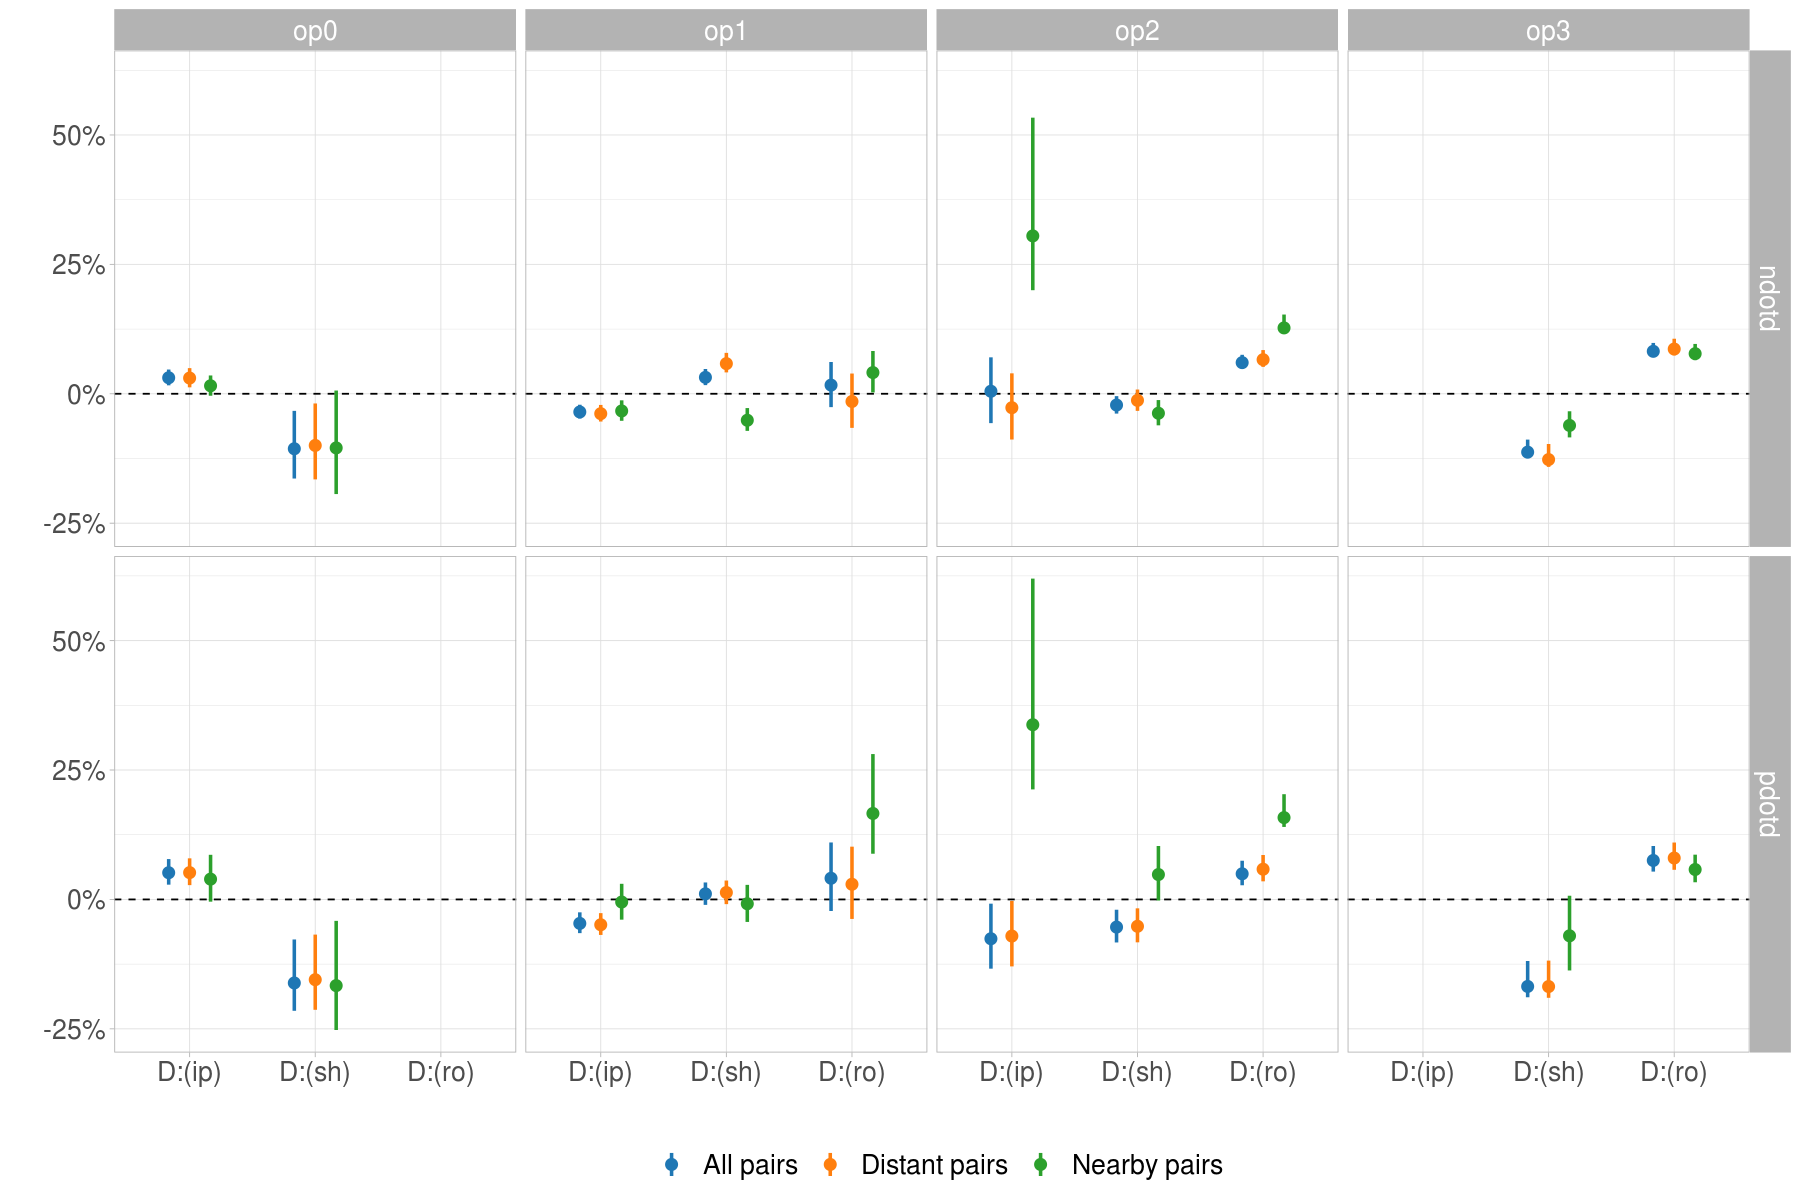

In [125]:


dyad_coefs2 %>%
    filter(var != 'op3_dp1') %>%
    separate(var, into = c('origin policy', 'destination policy')) %>%
    mutate(`destination policy` = ifelse(str_detect(`destination policy`, 'p1'), 'D:(ip)', 
                                        ifelse(str_detect(`destination policy`, 'p2'), 'D:(sh)', 'D:(ro)')),
           `destination policy` = factor(`destination policy`, levels = c('D:(ip)', 'D:(sh)', 'D:(ro)'))) %>%
    mutate(estimate = exp(estimate) - 1,
           u95ci   = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1) %>%
    filter(!is.na(`destination policy`)) %>%
    ggplot(aes(x = `destination policy`, y = estimate, color = type)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.5), size = 3) +
    geom_linerange(aes(ymin = l95ci, ymax = u95ci), 
                   position = position_dodge(0.5), size = 1) +
    scale_color_d3() +
    xlab('') + 
    ylab('') +
    labs(color = '') + 
    scale_color_d3(labels = c('All pairs', 'Distant pairs', 'Nearby pairs')) + 
    scale_y_continuous(labels = scales::percent) +
    facet_grid(dv ~ `origin policy`) +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> p

#ggsave('/home/mfzhao/p4.pdf', p, device = 'pdf', width = 6.5, height = 5, scale = 2)

p

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 12 rows [1, 2, 13, 14, 25, 26, 37, 38, 49, 50, 61, 62].”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



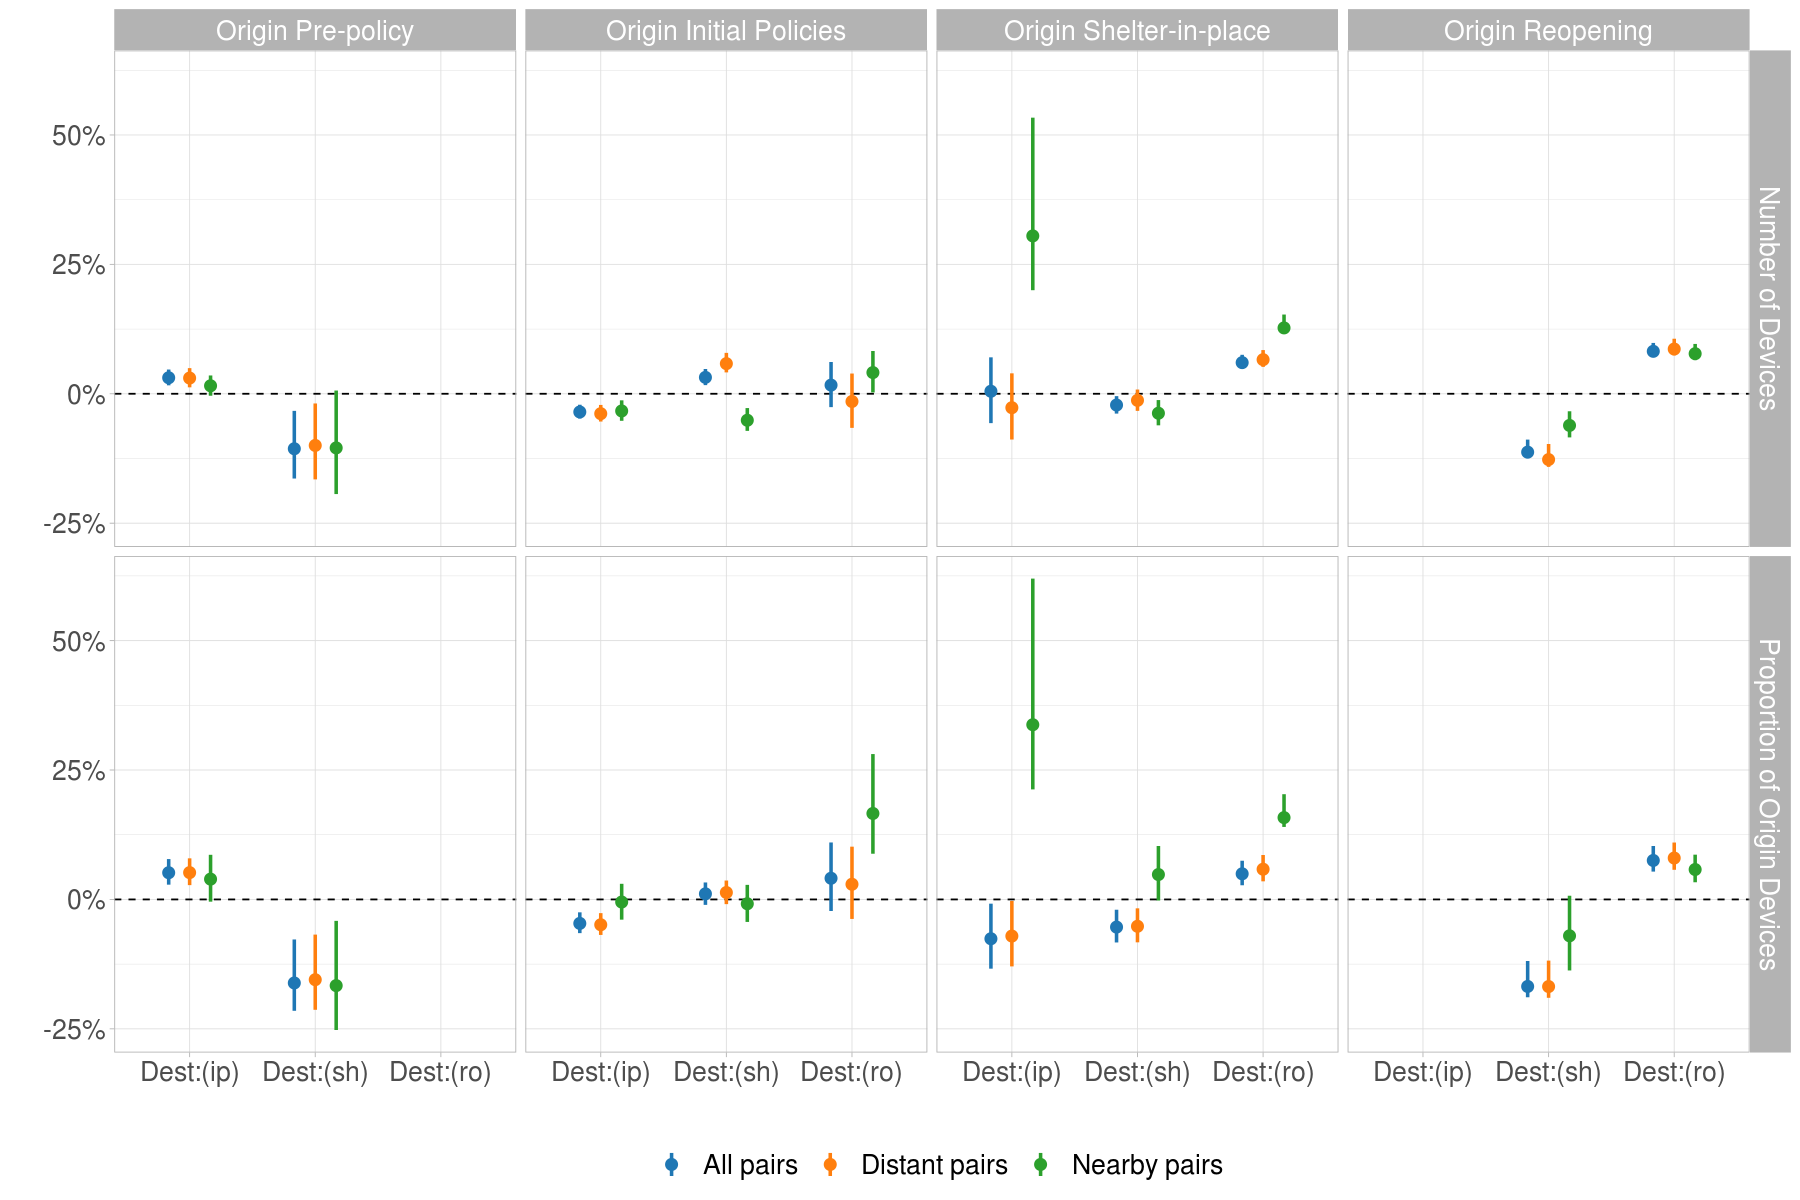

In [128]:
pn <- c('op0'   = "Origin Pre-policy",
        'op1'   = "Origin Initial Policies",
        'op2'   = "Origin Shelter-in-place",
        'op3'   = "Origin Reopening",
        'ndotd' = 'Number of Devices',
        'pdotd' = 'Proportion of Origin Devices')

dyad_coefs2 %>%
    filter(var != 'op3_dp1') %>%
    separate(var, into = c('origin policy', 'destination policy')) %>%
    mutate(`destination policy` = ifelse(str_detect(`destination policy`, 'p1'), 'D:(ip)', 
                                        ifelse(str_detect(`destination policy`, 'p2'), 'D:(sh)', 'D:(ro)')),
           `destination policy` = factor(`destination policy`, levels = c('D:(ip)', 'D:(sh)', 'D:(ro)'))) %>%
    mutate(estimate = exp(estimate) - 1,
           u95ci   = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1) %>%
    filter(!is.na(`destination policy`)) %>%
    ggplot(aes(x = `destination policy`, y = estimate, color = type)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.5), size = 3) +
    geom_linerange(aes(ymin = l95ci, ymax = u95ci), 
                   position = position_dodge(0.5), size = 1) +
    scale_color_d3() +
    xlab('') + 
    ylab('') +
    labs(color = '') + 
    scale_color_d3(labels = c('All pairs', 'Distant pairs', 'Nearby pairs')) + 
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c('Dest:(ip)',
                                'Dest:(sh)',
                                'Dest:(ro)')) + 
    facet_grid(dv ~ `origin policy`, labeller = as_labeller(pn)) +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> p

#ggsave('/home/mfzhao/p4.pdf', p, device = 'pdf', width = 6.5, height = 5, scale = 2)

p